In [2]:
from datasets import load_dataset, concatenate_datasets
from transformers import pipeline
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
combined_dataset = load_dataset("mkita/topic-discovery-for-news-articles", split="train")


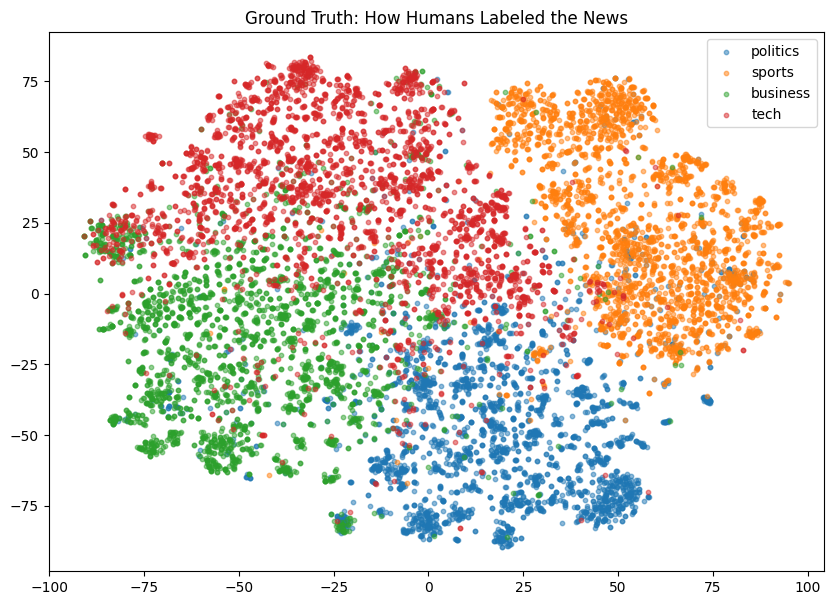

In [5]:
X = np.array(combined_dataset["embeddings"])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10, 7))
for label_id in np.unique(combined_dataset["label"]):
    mask = np.array(combined_dataset["label"]) == label_id
    label_name = combined_dataset.filter(lambda x: x["label"] == label_id)[0]["label_description"]
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=label_name, alpha=0.5, s=10)

plt.title("Ground Truth: How Humans Labeled the News")
plt.legend()
plt.show()

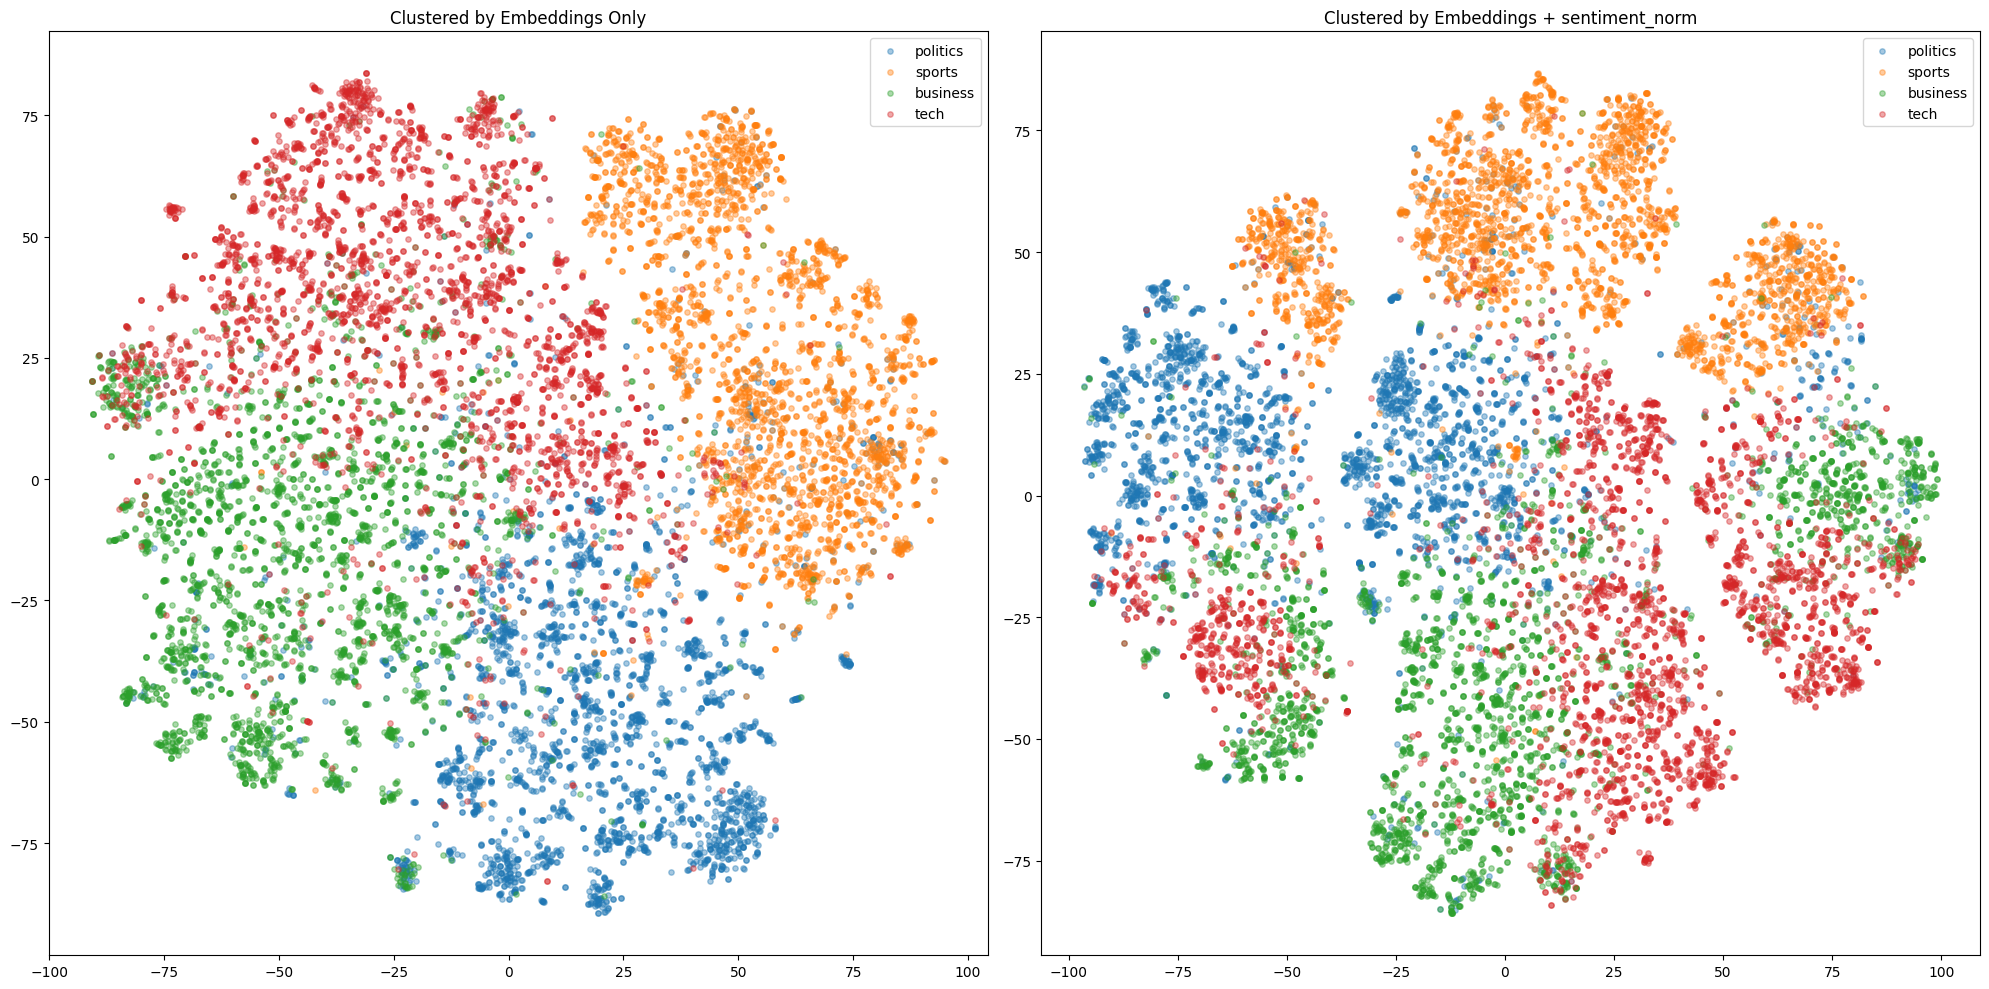

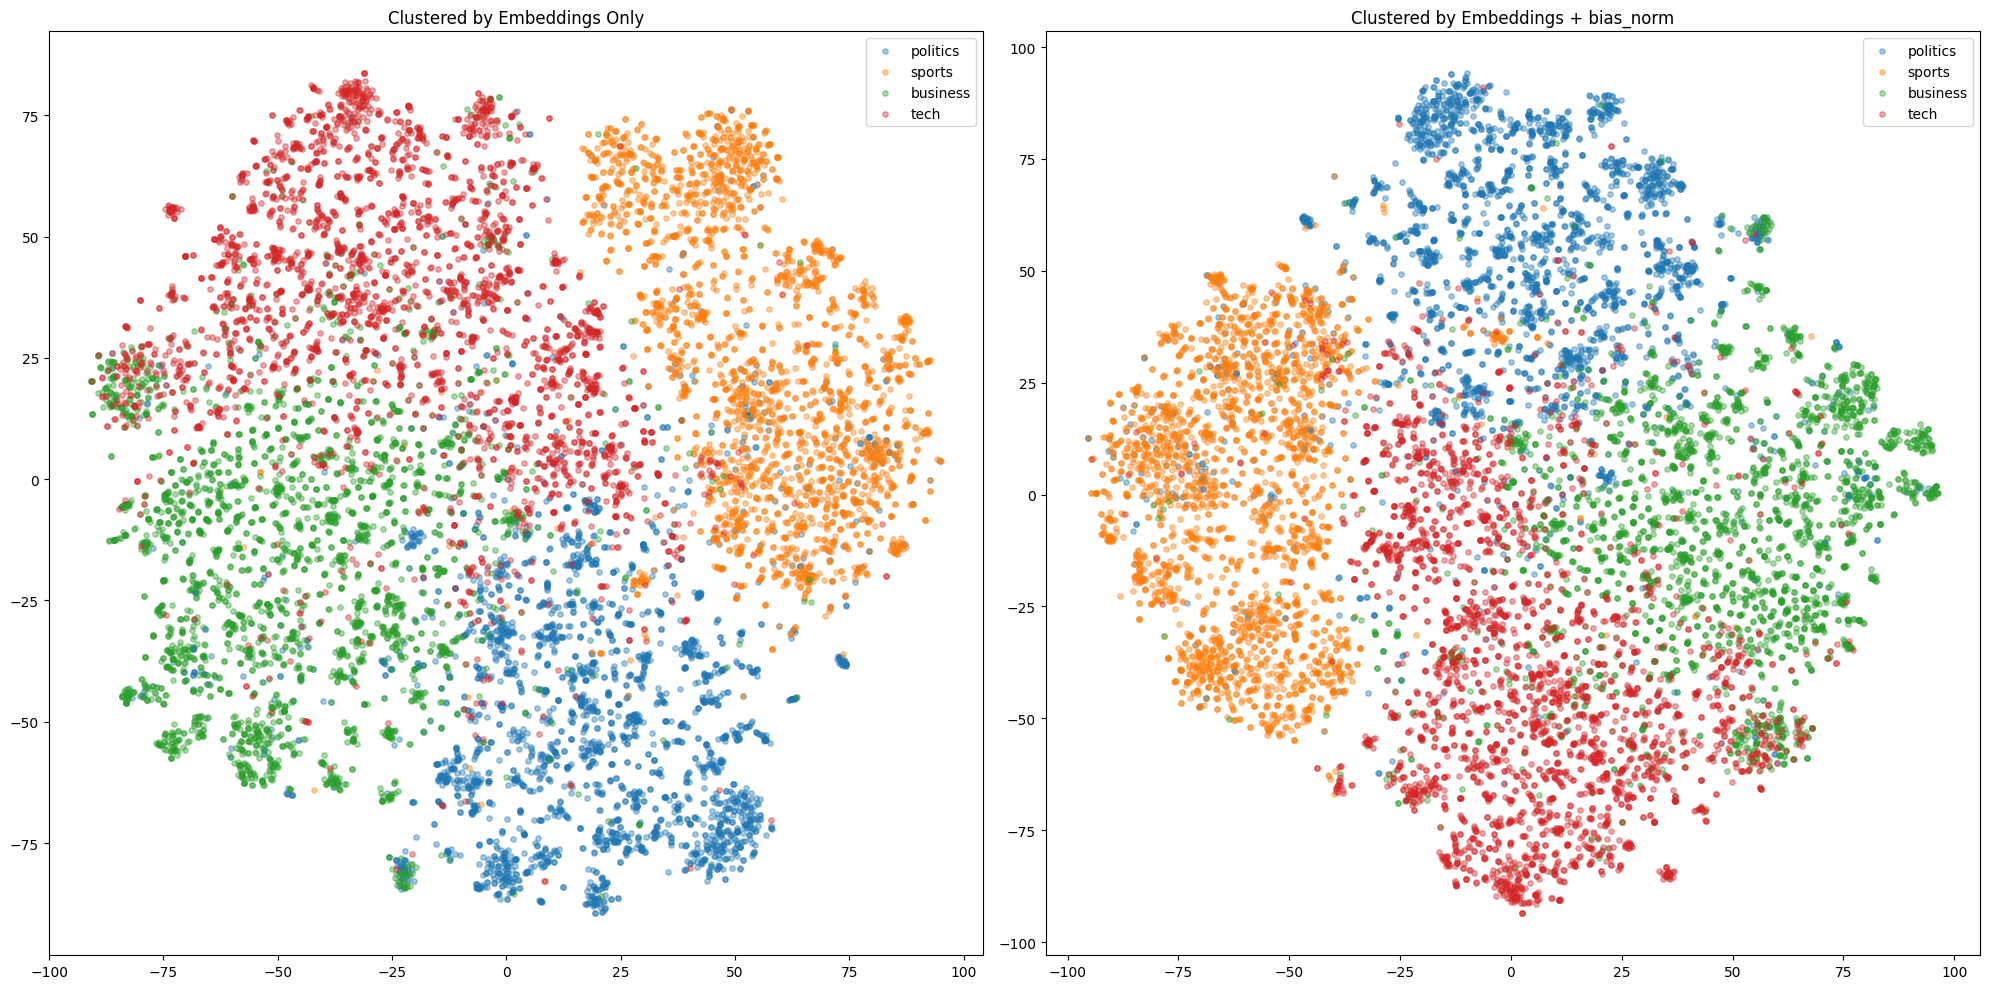

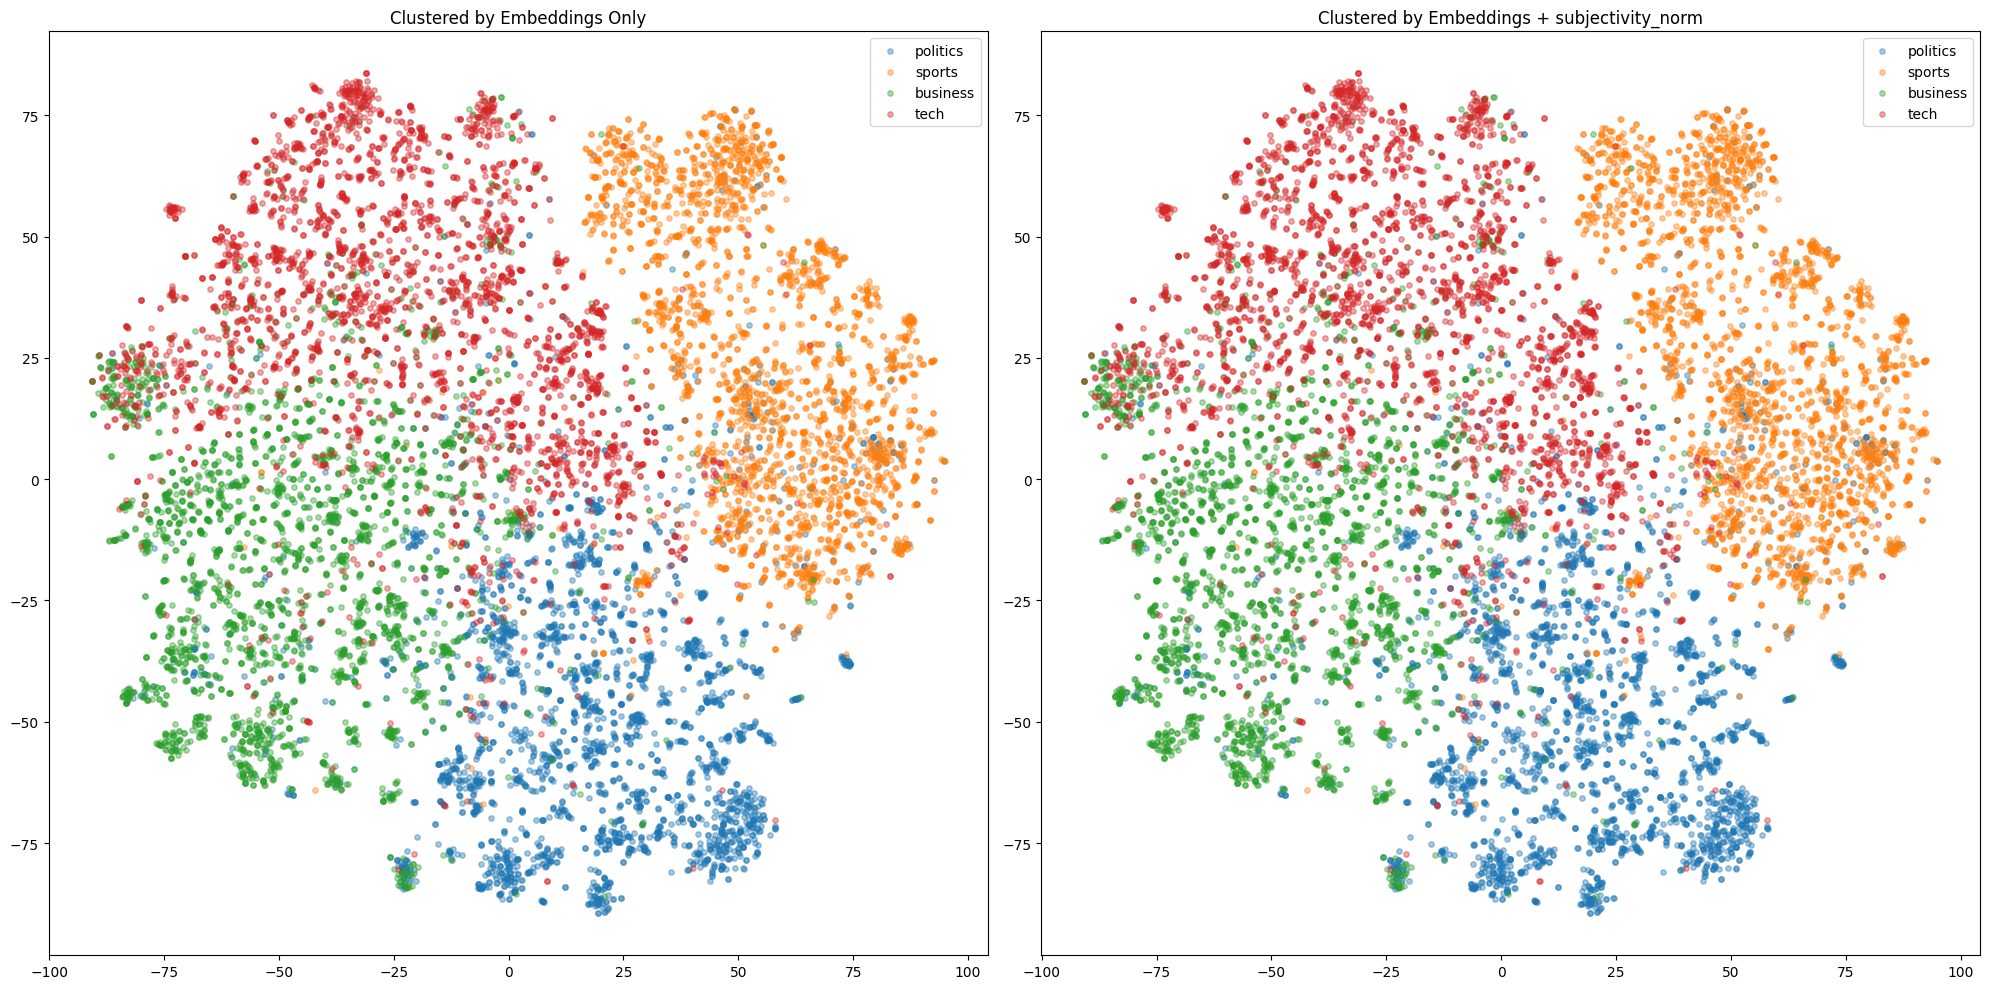

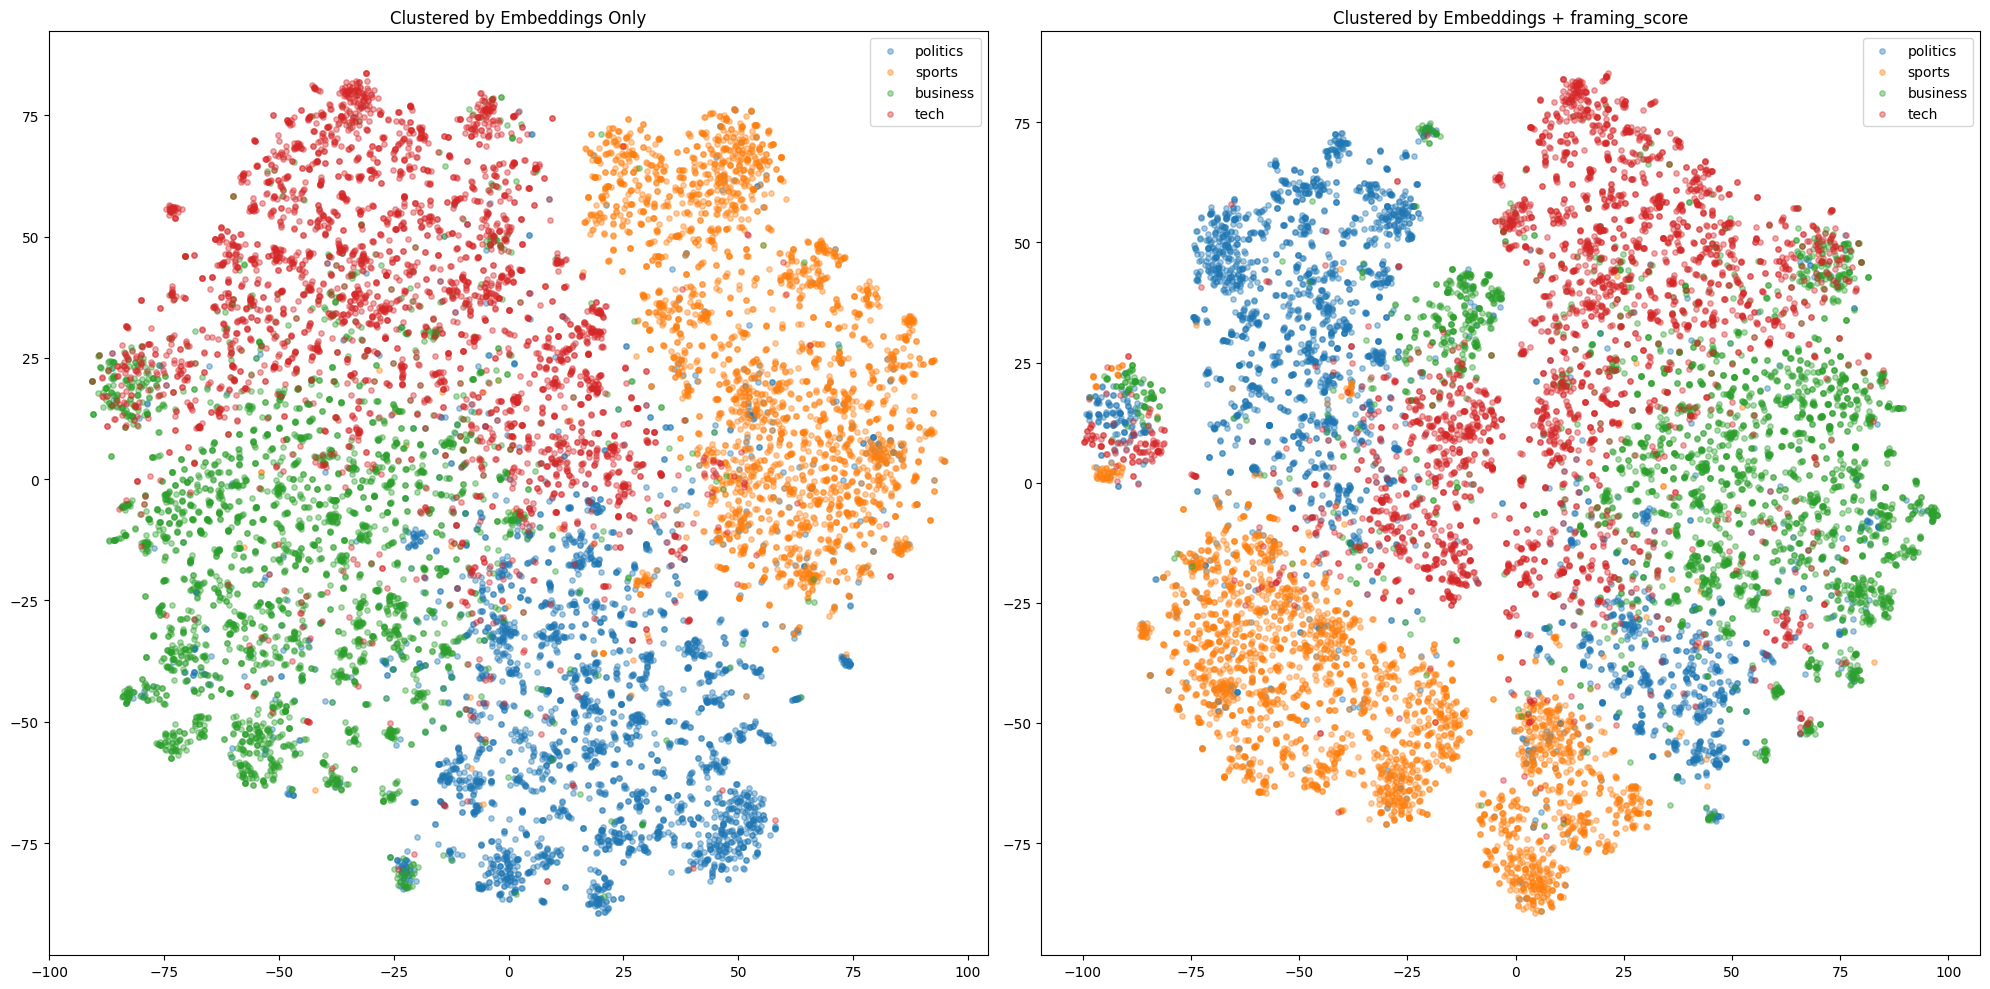

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

emb = np.array(combined_dataset["embeddings"])
labels = np.array(combined_dataset["label"])
unique_labels = np.unique(labels)

label_map = {
    lid: combined_dataset.filter(lambda x: x["label"] == lid)[0]["label_description"] 
    for lid in unique_labels
}

tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d_pure = tsne_model.fit_transform(emb)

metadata_columns = ["sentiment_norm", "bias_norm", "subjectivity_norm", "framing_score"]

for col in metadata_columns:
    meta_val = np.array(combined_dataset[col]).reshape(-1, 1)
    
    X_enriched = np.concatenate([emb, meta_val], axis=1)
    
    X_2d_enriched = tsne_model.fit_transform(X_enriched)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    for label_id in unique_labels:
        mask = (labels == label_id)
        label_name = label_map[label_id]
        
        ax1.scatter(X_2d_pure[mask, 0], X_2d_pure[mask, 1], label=label_name, alpha=0.4, s=15)
        ax2.scatter(X_2d_enriched[mask, 0], X_2d_enriched[mask, 1], label=label_name, alpha=0.4, s=15)

    ax1.set_title("Clustered by Embeddings Only")
    ax2.set_title(f"Clustered by Embeddings + {col}")
    ax1.legend()
    ax2.legend()
    
    plt.tight_layout()
    file_name = f"embeddings vs {col}.png"
    plt.savefig(file_name)

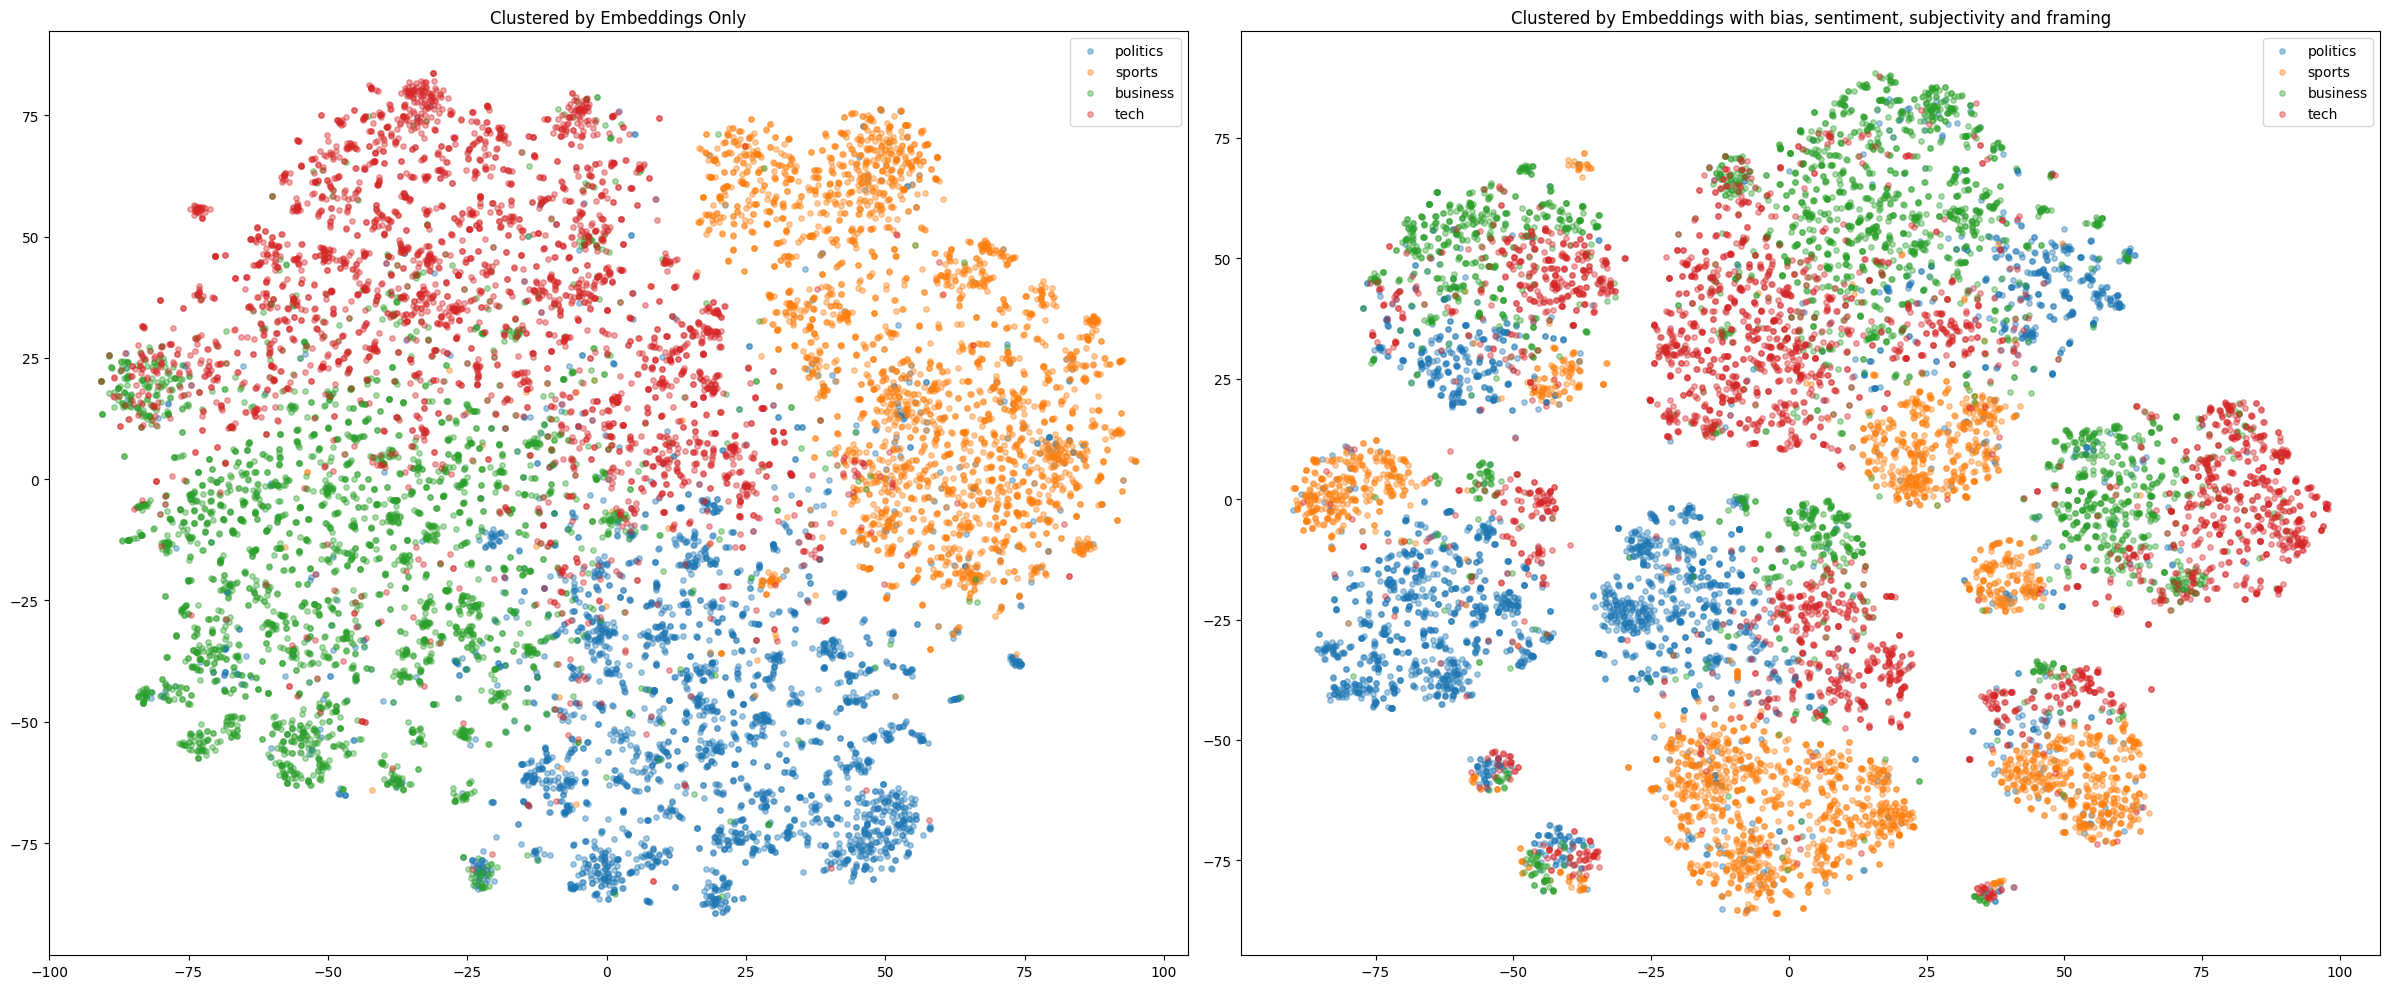

In [8]:
X_full_enriched = np.array(combined_dataset["full_feature_vector"])

X_2d_enriched = tsne_model.fit_transform(X_full_enriched)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

for label_id in unique_labels:
    mask = (labels == label_id)
    label_name = label_map[label_id]
    
    ax1.scatter(X_2d_pure[mask, 0], X_2d_pure[mask, 1], label=label_name, alpha=0.4, s=15)
    ax2.scatter(X_2d_enriched[mask, 0], X_2d_enriched[mask, 1], label=label_name, alpha=0.4, s=15)

ax1.set_title("Clustered by Embeddings Only")
ax2.set_title(f"Clustered by Embeddings with bias, sentiment, subjectivity and framing")
ax1.legend()
ax2.legend()

plt.tight_layout()
file_name = f"embeddings_vs_full_metadata_view.png"
plt.savefig(file_name)

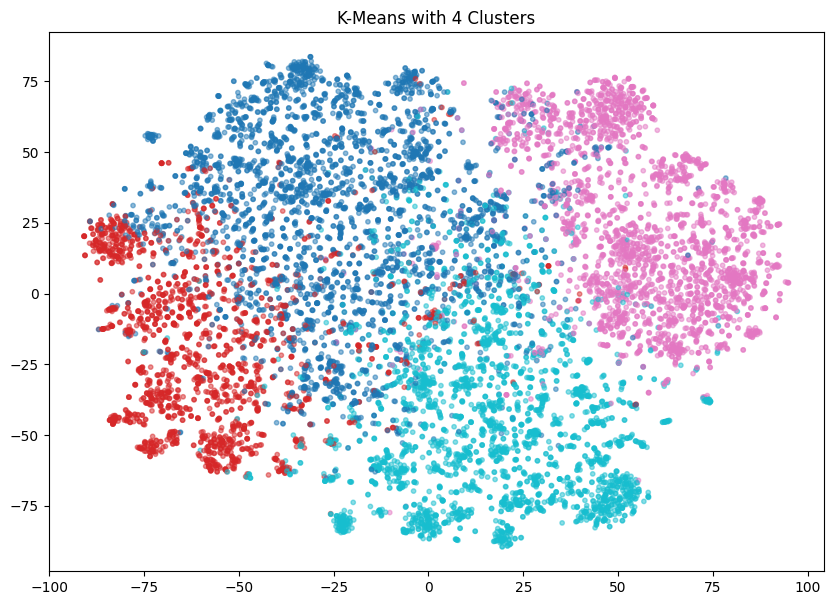

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

num_labels = len(np.unique(combined_dataset["label"]))
kmeans = KMeans(n_clusters=num_labels, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.5, s=10)
plt.title(f"K-Means with {num_labels} Clusters")
plt.show()

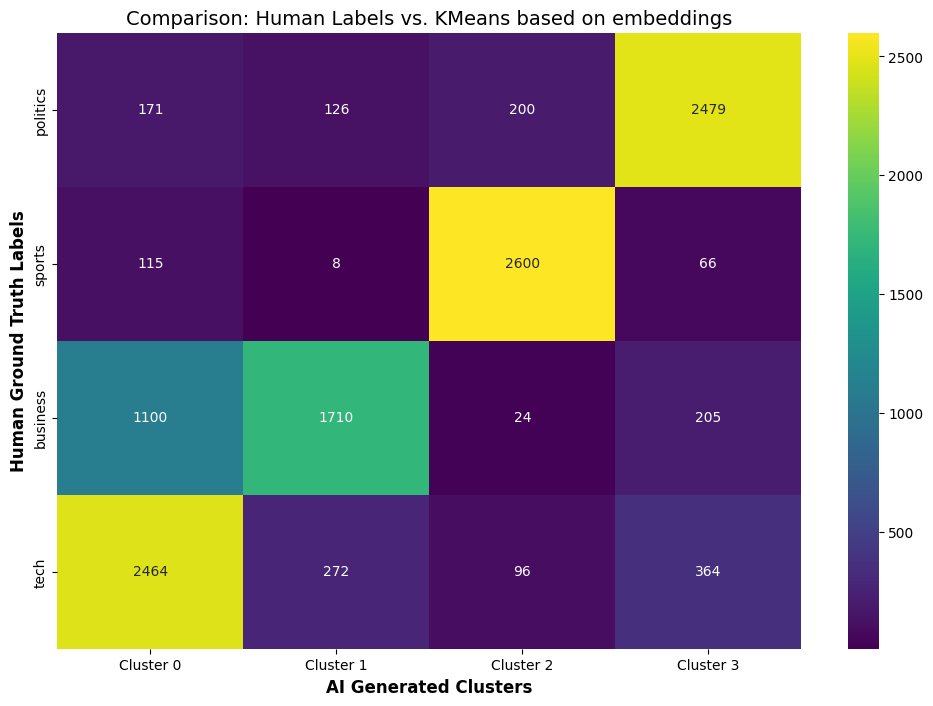

In [ ]:

num_labels = len(np.unique(combined_dataset["label"]))
kmeans = KMeans(n_clusters=num_labels, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.5, s=10)
plt.title(f"AI Discovery: K-Means with {num_labels} Clusters")
plt.show()

unique_labels = sorted(list(set(combined_dataset["label"])))
label_descriptions = []

for label_id in unique_labels:
    desc = combined_dataset.filter(lambda x: x["label"] == label_id)[0]["label_description"]
    label_descriptions.append(desc)

cm = confusion_matrix(combined_dataset["label"], kmeans_labels+1)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=[f"Cluster {i}" for i in range(num_labels)],
    yticklabels=label_descriptions
)

plt.xlabel('Generated Clusters', fontsize=12, fontweight='bold')
plt.ylabel('Human Ground Truth Labels', fontsize=12, fontweight='bold')
plt.title('Comparison: Human Labels vs. KMeans based on embeddings', fontsize=14)
plt.show()

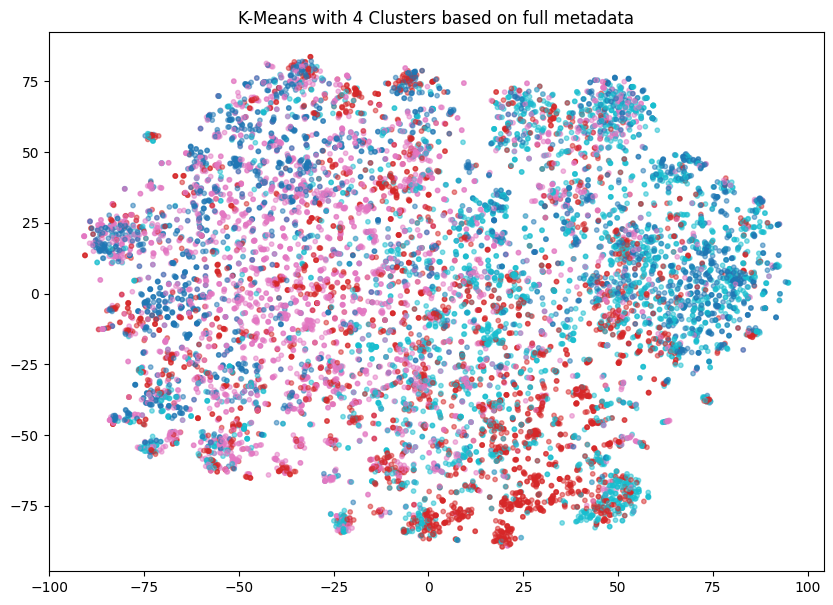

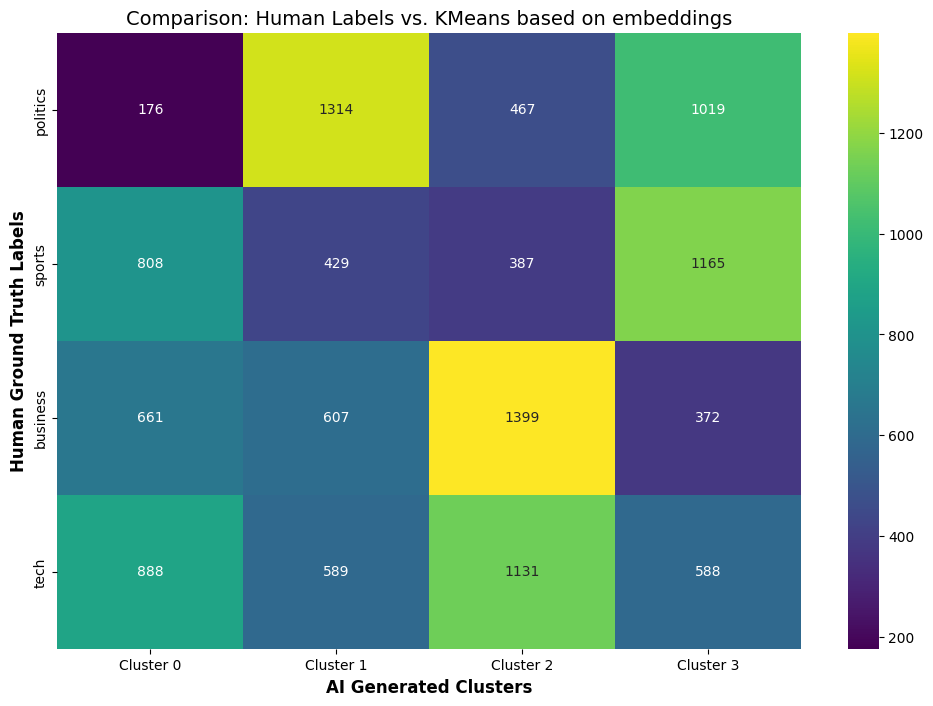

In [14]:
num_labels = len(np.unique(combined_dataset["label"]))
kmeans = KMeans(n_clusters=num_labels, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_2d_enriched)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.5, s=10)
plt.title(f"K-Means with {num_labels} Clusters based on full metadata")
plt.show()

unique_labels = sorted(list(set(combined_dataset["label"])))
label_descriptions = []

for label_id in unique_labels:
    desc = combined_dataset.filter(lambda x: x["label"] == label_id)[0]["label_description"]
    label_descriptions.append(desc)

cm = confusion_matrix(combined_dataset["label"], kmeans_labels+1)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=[f"Cluster {i}" for i in range(num_labels)],
    yticklabels=label_descriptions
)

plt.xlabel('AI Generated Clusters', fontsize=12, fontweight='bold')
plt.ylabel('Human Ground Truth Labels', fontsize=12, fontweight='bold')
plt.title('Comparison: Human Labels vs. KMeans based on embeddings', fontsize=14)
plt.show()